# EDA

Импортируем библиотеки и прописываем пути, устанавливаем random_state.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
PATH_COVERS = 'data/raw/covers.json'
PATH_LYRICS = 'data/raw/lyrics.json'
PATH_META = 'data/raw/meta.json'

RANDOM_STATE = 54321

## Изучение датасета covers 

Изучим данные в датасете covers данный датасет содержит следующие столбцы  
- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

In [3]:
df_covers = pd.read_json(PATH_COVERS, lines=True)
df_covers.head()

,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER


Выведем информацию по датасету

In [4]:
df_covers.shape

(71597, 3)

In [5]:
df_covers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


У нас 71597 записей при этом в id оригинальных треков есть много пропусков

Посмотрим на соотношение оригинальных и версий и каверов в полном датасете

In [6]:
df_group = df_covers.groupby('track_remake_type')['track_id'].agg('count').reset_index()

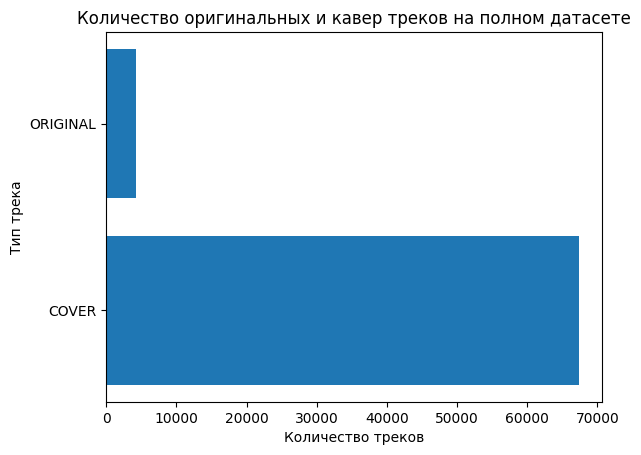

In [7]:
plt.title('Количество оригинальных и кавер треков на полном датасете')
plt.barh(df_group['track_remake_type'], df_group['track_id'])
plt.xlabel('Количество треков')
plt.ylabel('Тип трека')
plt.show()

Посмотрим на соотношение оригинальных и версий и каверов в датасете без пропусков

In [8]:
df_group = df_covers.dropna().groupby('track_remake_type')['track_id'].agg('count').reset_index()

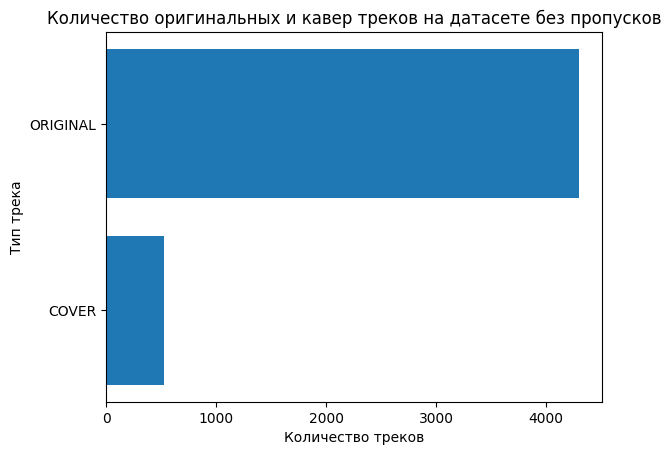

In [9]:
plt.title('Количество оригинальных и кавер треков на датасете без пропусков')
plt.barh(df_group['track_remake_type'], df_group['track_id'])
plt.xlabel('Количество треков')
plt.ylabel('Тип трека')
plt.show()

Посмотрим сколько треков имеют не только ссылку на оригинальный id, но и сам трек находится в выборке

In [10]:
df_covers_copy = df_covers.copy(deep=True)
df = df_covers[['track_id']].merge(df_covers_copy, left_on='track_id', right_on='original_track_id')
df[df['track_remake_type']=='COVER'].shape[0]

297

Всего у нас 297 таких треков, что учитывая будущую размерность векторизированных данных очень мало. Однако это единственные размеченные данные с которыми мы можем корректно работать и в дальнейшем оценивать качество нашей модели.

In [11]:
df_covers[df_covers['track_remake_type']=='COVER'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 67304 entries, 4 to 71594
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  528 non-null    object
 1   track_id           67304 non-null  object
 2   track_remake_type  67304 non-null  object
dtypes: object(3)
memory usage: 2.1+ MB


## Изучение датасета lyrics

Изучим данные в датасете lyrics данный датасет содержит следующие столбцы  
- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

In [57]:
df_lyrics = pd.read_json(PATH_LYRICS, lines=True)
df_lyrics.head()

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659


Выведем информацию по датасету

In [58]:
df_lyrics.shape

(11414, 3)

In [15]:
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


У нас есть слова только для 11414 песен. Посмотрим количество уникальных текстов по сравнению с количеством песен.

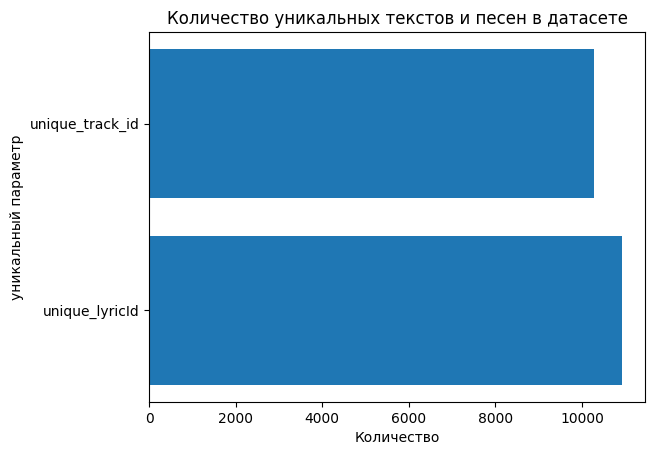

In [63]:
plt.title('Количество уникальных текстов и пеcен в датасете')
plt.barh(['unique_lyricId','unique_track_id'], [len(df_lyrics['lyricId'].unique()), len(df_lyrics['track_id'].unique())])
plt.xlabel('Количество')
plt.ylabel('уникальный параметр')
plt.show()

In [65]:
print(f'Количество строк в датасете lyrics: {df_lyrics.shape[0]}')

Количество строк в датасете: 11414


In [25]:
print(f'Количество уникльных текстов: {len(df_lyrics["lyricId"].unique())}')

Количество уникльных текстов: 10915


In [64]:
print(f'Количество уникльных треков: {len(df_lyrics["track_id"].unique())}')

Количество уникльных треков: 10277


Как видим количество уникальных текстов меньше количества уникальных песен примерно на 500.

Создадим список не уникальных текстов

In [39]:
df = df_lyrics["lyricId"].value_counts().reset_index()
df = df[df['count'] != 1]
ununic_lirics = list(df['lyricId'].values)

Присоединим датасет df_covers к df_lyrics и посмотрим на их пересечение

In [50]:
df_covers_lyrics = df_covers.merge(df_lyrics, on = 'track_id', how='left')

In [51]:
df_covers_lyrics.shape

(72571, 5)

Посмотрим у каких треков не уникальные тексты

In [52]:
df_ununic = df_covers_lyrics[df_covers_lyrics['lyricId'].isin(ununic_lirics)]
df_ununic

,original_track_id,track_id,track_remake_type,lyricId,text
4,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,e5b1b57090b728e8d98d2b4d9b781bf4,"Yeah!... yeah!... remember the time, baby... y..."
5,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL,b6625d84706fefe8782e63bd36067bc2,In a state of emergency...\n\nI ain't got no m...
51,None,fdccddea8522e14b9d8a41551d9256fa,COVER,2eeef0aabf024b11b21d68f642c7648f,"Yeah, yeah, yeah, yeah, yeah, yeah\nOh yeah, y..."
55,deb9b9598176a0bab1212d430b10bd04,bfa9c5c62c08a0db763e2a2284e3d1b2,COVER,29a568cf5c214ebe28a5cf8c88a1623a,Sweet dreams are made of this\nWho am I to dis...
56,b785f0c8bacf5ff5809928e60934704b,b785f0c8bacf5ff5809928e60934704b,ORIGINAL,f68e7cf17a599d58853852b6155686a7,"In the day, in the night\nSay it right, say it..."
...,...,...,...,...,...
71518,f45d36a20a118ee7651dfe930093ef11,f45d36a20a118ee7651dfe930093ef11,ORIGINAL,c579b8b061b724255e3a5a8d7b5bd849,Вдаль уносят мечты\nСпит город\nТы опять говор...
71543,None,63e3612b33b2a985cab7c462c184f66c,COVER,e593a047a804726e719789eb3796838d,Took a ride\nTo the end of the line where\nNo ...
71718,None,0dca178f1744f26d84b8dce21774a77c,COVER,714939b74d53d7386052ba474546b6aa,Тихо лужи покрывает лёд\nПомнишь мы с тобою\nЦ...
72083,31cdfa7557671b936755d661bcad69c4,31cdfa7557671b936755d661bcad69c4,ORIGINAL,9166e35830456fe64f461080027c71bf,"Тёмный, мрачный коридор\nЯ на цыпочках, как во..."


In [53]:
(df_ununic['track_remake_type'] == 'COVER').sum()

744

In [54]:
len(df_ununic['track_id'].unique())

711

10277